# Find RF Interference Accesses

This notebook defines a scenario with 2 satellites & 1 ground station and computes accesses in which satellites RF beams might be interfering with each other due to their proximity during a pass. It can be scaled-up to consider multiple satellites as well as multiple ground stations.

## Setup

In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go

from ostk.mathematics.object import RealInterval

from ostk.physics import Environment
from ostk.physics.coordinate import Position
from ostk.physics.coordinate import Frame
from ostk.physics.coordinate.spherical import AER
from ostk.physics.coordinate.spherical import LLA
from ostk.physics.environment.object import Celestial
from ostk.physics.time import DateTime
from ostk.physics.time import Duration
from ostk.physics.time import Instant
from ostk.physics.time import Interval
from ostk.physics.time import Scale
from ostk.physics.unit import Length
from ostk.physics.unit import Angle

from ostk.astrodynamics import Access
from ostk.astrodynamics import Trajectory
from ostk.astrodynamics.access import Generator as AccessGenerator
from ostk.astrodynamics.access import AccessTarget
from ostk.astrodynamics.access import VisibilityCriterion
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory import State
from ostk.astrodynamics.trajectory.orbit.model import SGP4
from ostk.astrodynamics.trajectory.orbit.model.sgp4 import TLE

## Define Scenario

- Start time of the analysis
- Duration of the analysis
- Step size at which states are computed
- Tolerance to find the interferences
- Ground station location
    - Minimum elevation angle
    - Interference angle

In [2]:
start_instant: Instant = Instant.date_time(
    DateTime(2023, 1, 3, 0, 0, 0),
    Scale.UTC,
)
duration: Duration = Duration.days(7.0)
step: Duration = Duration.seconds(10.0)
tolerance: Duration = Duration.seconds(1.0)
min_elevation_angle: Angle = Angle.degrees(3.0)
interference_angle: Angle = Angle.degrees(5.0)
ground_station_lla: LLA = LLA(
    Angle.degrees(70.0),  # Latitude
    Angle.degrees(160.0),  # Longitude
    Length.meters(0.0),  # Altitude
)

## Define Satellites

- TLE of 'satellite 1'
- TLE of 'satellite 2'

In [3]:
tle_1 = TLE(
    "1 55076U 23001BV  23146.17959645  .00004328  00000-0  23719-3 0  9993",
    "2 55076  97.4793 205.9529 0016244  89.9523 270.3571 15.14609100 21723",
)

tle_2 = TLE(
    "1 48915U 21059AN  23146.32782040  .00004955  00000-0  24678-3 0  9999",
    "2 48915  97.5954 279.7041 0010303 354.9434   5.1694 15.18004448105867",
)

## Interference Filter

Define a `StateFilter` that can be passed to the `AccesGenerator`. This filter detects when:
- satellite 1 is above the ground station minimum elevation and
- satellite 2 is above the ground station minimum elevation and
- satellite 1 and satellite 2 angular separation (as seen from the ground station) is below the interference angle

In [4]:
class InterferenceFilter:
    """Interference filter. A state filter that computes when two satellites are
    both within the ground station and inteference cones.
    """

    def __init__(
        self,
        earth: Celestial,
        ground_station_lla: LLA,
        min_elevation_angle: Angle,
        interference_angle: Angle,
        start_instant: Instant = None,
        stop_instant: Instant = None,
    ):
        self._ned_frame: Frame = earth.get_frame_at(
            ground_station_lla, earth.FrameType.NED
        )
        self._ground_station_pos_ned: Position = Position(
            [0.0, 0.0, 0.0],
            Length.Unit.Meter,
            self._ned_frame,
        )
        self._min_elevation_angle_in_radians: float = min_elevation_angle.in_radians()
        self._interference_angle_in_radians: float = interference_angle.in_radians()

        if start_instant is not None and stop_instant is not None:
            self._total_span_in_seconds: float = Duration.between(
                start_instant, stop_instant
            ).in_seconds()
            self._previous_instant = start_instant

    def _is_in_ground_station_cone(
        self,
        satellite_pos_ned: Position,
    ) -> bool:
        """Returns True if the satellite (as seen from the ground station) is above
        the minimim elevation.
        """
        aer: AER = AER.from_position_to_position(
            self._ground_station_pos_ned, satellite_pos_ned, True
        )
        elevation_in_radians = aer.get_elevation().in_radians()
        return elevation_in_radians >= self._min_elevation_angle_in_radians

    def _is_interfering(
        self,
        satellite_1_pos_ned: Position,
        satellite_2_pos_ned: Position,
    ) -> bool:
        """Returns true if the satellites angular separation is within the (as seen
        from the ground station) interference angle.
        """
        satellite_1_coordinates = satellite_1_pos_ned.in_meters().get_coordinates()
        satellite_2_coordinates = satellite_2_pos_ned.in_meters().get_coordinates()

        satellite_1_unit = satellite_1_coordinates / np.linalg.norm(
            satellite_1_coordinates
        )
        satellite_2_unit = satellite_2_coordinates / np.linalg.norm(
            satellite_2_coordinates
        )

        angle_rad = np.arccos(
            np.clip(np.dot(satellite_1_unit, satellite_2_unit), -1.0, 1.0)
        )
        return angle_rad <= self._interference_angle_in_radians

    def filter_(
        self,
        satellite_1_state: State,
        satellite_2_state: State,
    ) -> bool:
        """Returns true if both satellites are both within the:
        - ground station line-of-sight
        - interference cone
        """
        instant = satellite_1_state.get_instant()

        satellite_1_pos_ned: Position = satellite_1_state.get_position().in_frame(
            self._ned_frame, instant
        )
        satellite_2_pos_ned: Position = satellite_2_state.get_position().in_frame(
            self._ned_frame, instant
        )

        return (
            self._is_in_ground_station_cone(satellite_1_pos_ned)
            and self._is_in_ground_station_cone(satellite_2_pos_ned)
            and self._is_interfering(satellite_1_pos_ned, satellite_2_pos_ned)
        )

## Run the analysis

Build and define environment objects

In [5]:
environment: Environment = Environment.default()
earth: Celestial = environment.access_celestial_object_with_name("Earth")

stop_instant: Instant = start_instant + duration
search_interval: RealInterval = Interval.closed(start_instant, stop_instant)

orbit_1: Orbit = Orbit(SGP4(tle_1), earth)
orbit_2: Orbit = Orbit(SGP4(tle_2), earth)

Build and define interference filter and access generator to find the 'interference' accesses.

In [6]:
interference_filter: InterferenceFilter = InterferenceFilter(
    earth=earth,
    ground_station_lla=ground_station_lla,
    min_elevation_angle=min_elevation_angle,
    interference_angle=interference_angle,
    start_instant=start_instant,
    stop_instant=stop_instant,
)

access_generator: AccessGenerator = AccessGenerator(
    environment=environment,
    step=step,
    tolerance=tolerance,
    state_filter=interference_filter.filter_,
)

visibility_criterion: VisibilityCriterion = VisibilityCriterion.from_line_of_sight(environment=environment)
access_target: AccessTarget = AccessTarget.from_trajectory(
    visibility_criterion=visibility_criterion,
    trajectory=orbit_1,
)

interfered_accesses = access_generator.compute_accesses(
    interval=search_interval,
    access_target=access_target,
    to_trajectory=orbit_2,
)

Display the number of 'interfered' accesses:

In [7]:
print(f"Number of interfered accesses: {len(interfered_accesses)}")

Number of interfered accesses: 7


Display the accesses themselves:

In [8]:
print(interfered_accesses)

[-- Access ------------------------------------------------------------------------------------------
    Type:                                    Complete                                 
    Acquisition Of Signal:                   2023-01-03 02:30:45.228.193.391 [UTC]    
    Time of Closest Approach:                2023-01-03 02:30:45.228.193.391 [UTC]    
    Loss Of Signal:                          2023-01-03 02:31:01.135.358.795 [UTC]    
    Duration:                                15.907.165.404                           
    Maximum Elevation:                       -0.13211797086212648 [rad]               
----------------------------------------------------------------------------------------------------
, -- Access ------------------------------------------------------------------------------------------
    Type:                                    Complete                                 
    Acquisition Of Signal:                   2023-01-03 04:05:25.780.017.886 [UTC]   

## Plots

Define a class to help plotting the satellite trajectories, highlighting the interfered accesses over the ground station.

In [9]:
class InterferencePlot:
    """Interference plot. It displays a 2D world map, with 1 ground station and
    multiple satellites, highlighting the interference accesses.
    """

    def __init__(
        self,
        interval: RealInterval,
        trajectory_step: Duration,
        interference_step: Duration,
        ground_station_lla: LLA,
        color: str,
    ):
        self._trajectory_grid: list[Instant] = interval.generate_grid(trajectory_step)
        self._interference_step: Instant = interference_step
        self._ned_frame: Frame = earth.get_frame_at(
            ground_station_lla, earth.FrameType.NED
        )
        self._ground_station_position_ned: Position = Position(
            [0.0, 0.0, 0.0],
            Length.Unit.Meter,
            self._ned_frame,
        )
        self._data = []
        self._data.append(
            dict(
                type="scattergeo",
                lon=[float(ground_station_lla.get_longitude().in_degrees())],
                lat=[float(ground_station_lla.get_latitude().in_degrees())],
                mode="markers",
                marker=dict(
                    size=10,
                    color=color,
                ),
            )
        )

    def _generate_and_append_data(
        self, data: list[list[float]], trajectory: Trajectory, grid: list[Instant]
    ) -> None:
        for state in trajectory.get_states_at(grid):
            lla: LLA = LLA.cartesian(
                state.get_position()
                .in_frame(Frame.ITRF(), state.get_instant())
                .get_coordinates(),
                earth.get_equatorial_radius(),
                earth.get_flattening(),
            )
            data.append(
                [
                    float(lla.get_longitude().in_degrees()),
                    float(lla.get_latitude().in_degrees()),
                ]
            )

    def _append_line(
        self, df: pd.DataFrame, width: int, rgb: list[int], alpha: float
    ) -> None:
        self._data.append(
            dict(
                type="scattergeo",
                lon=df["Longitude"],
                lat=df["Latitude"],
                mode="lines",
                line=dict(
                    width=width,
                    color=f"rgba({str(rgb[0])},{str(rgb[1])},{str(rgb[2])},{str(alpha)})",
                ),
            )
        )

    def add_satellite(
        self,
        trajectory: Trajectory,
        interference_accesses: list[Access],
        rgb: list[int],
    ) -> None:
        """Adds a satellite trajectory to the plot, including a highligh ot the interference
        accesses.
        """

        # Satellite trajectory
        satellite_trajectory_data: list[list[float]] = []
        self._generate_and_append_data(
            satellite_trajectory_data, trajectory, self._trajectory_grid
        )
        satellite_trajectory_df: pd.Dataframe = pd.DataFrame(
            satellite_trajectory_data, columns=["Longitude", "Latitude"]
        )
        self._append_line(satellite_trajectory_df, 1, rgb, 0.1)

        # Satellite interferences
        for interference_access in interference_accesses:
            satellite_interference_data: list[list[float]] = []
            self._generate_and_append_data(
                satellite_interference_data,
                trajectory,
                interference_access.get_interval().generate_grid(
                    self._interference_step
                ),
            )
            satellite_interference_df: pd.Dataframe = pd.DataFrame(
                satellite_interference_data, columns=["Longitude", "Latitude"]
            )
            self._append_line(satellite_interference_df, 2, rgb, 1.0)

    def get_figure(self):
        """Displays the figure."""
        layout = dict(
            title=None,
            showlegend=False,
            height=600,
            width=1200,
            geo=dict(
                showland=True,
                landcolor="rgba(243, 243, 243)",
                countrycolor="rgb(204, 204, 204)",
            ),
        )

        figure: go.Figure = go.Figure(data=self._data, layout=layout)
        return figure

Build the interference plot, with the ground station and time grid configuration.

In [10]:
interference_plot = InterferencePlot(
    interval=search_interval,
    trajectory_step=Duration.minutes(5.0),
    interference_step=Duration.seconds(10.0),
    ground_station_lla=ground_station_lla,
    color="green",
)

Add both satellite trajectories:

In [11]:
interference_plot.add_satellite(
    trajectory=orbit_1,
    interference_accesses=interfered_accesses,
    rgb=[180, 0, 0],
)

interference_plot.add_satellite(
    trajectory=orbit_2,
    interference_accesses=interfered_accesses,
    rgb=[0, 0, 180],
)

Show the plot:

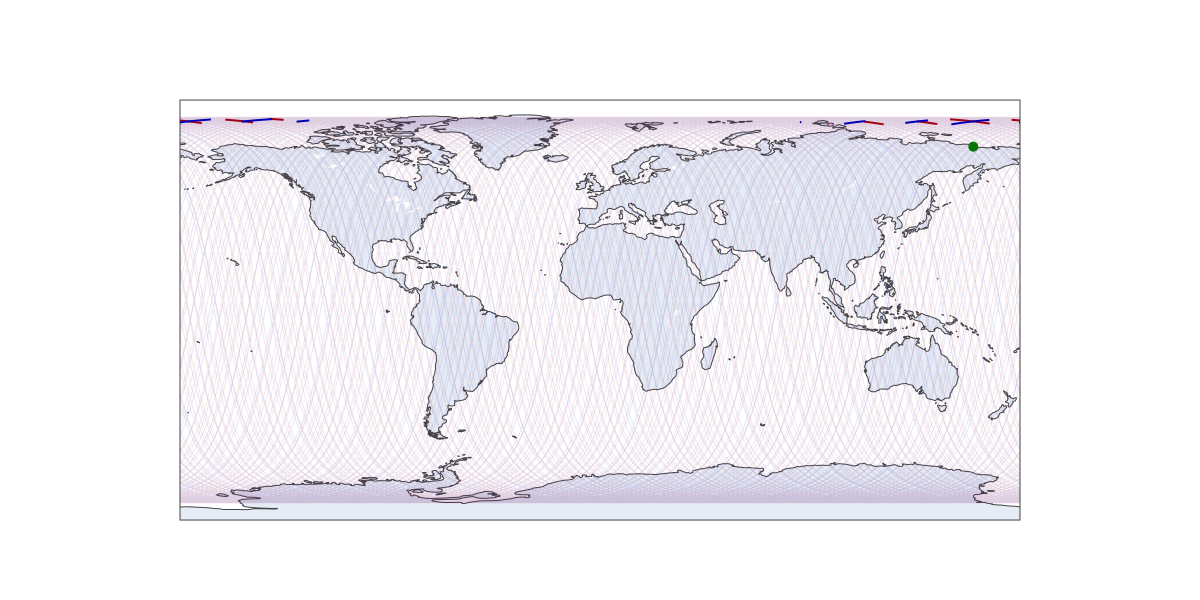

In [12]:
interference_plot.get_figure().show("svg")